In [80]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # drawing
import seaborn as sns  # pretty drawing
import os  # file operations
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_squared_error,
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
sns.set()
sns.set_style('darkgrid', {
    'axes.facecolor': '#1d2021',
    'axes.edgecolor': 'green',
    'grid.color': 'green',
    'grid.linestyle': ':',
})

whole_dataset = pd.read_csv('predictive_maintenance.csv')
print(f'total: {len(whole_dataset)}')
whole_dataset.head()

total: 10000


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [81]:
cleaned_dataset = whole_dataset.drop(['Type', 'UDI', 'Product ID', 'Target'], axis=1)
cleaned_dataset.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Failure Type
0,298.1,308.6,1551,42.8,0,No Failure
1,298.2,308.7,1408,46.3,3,No Failure
2,298.1,308.5,1498,49.4,5,No Failure
3,298.2,308.6,1433,39.5,7,No Failure
4,298.2,308.7,1408,40.0,9,No Failure


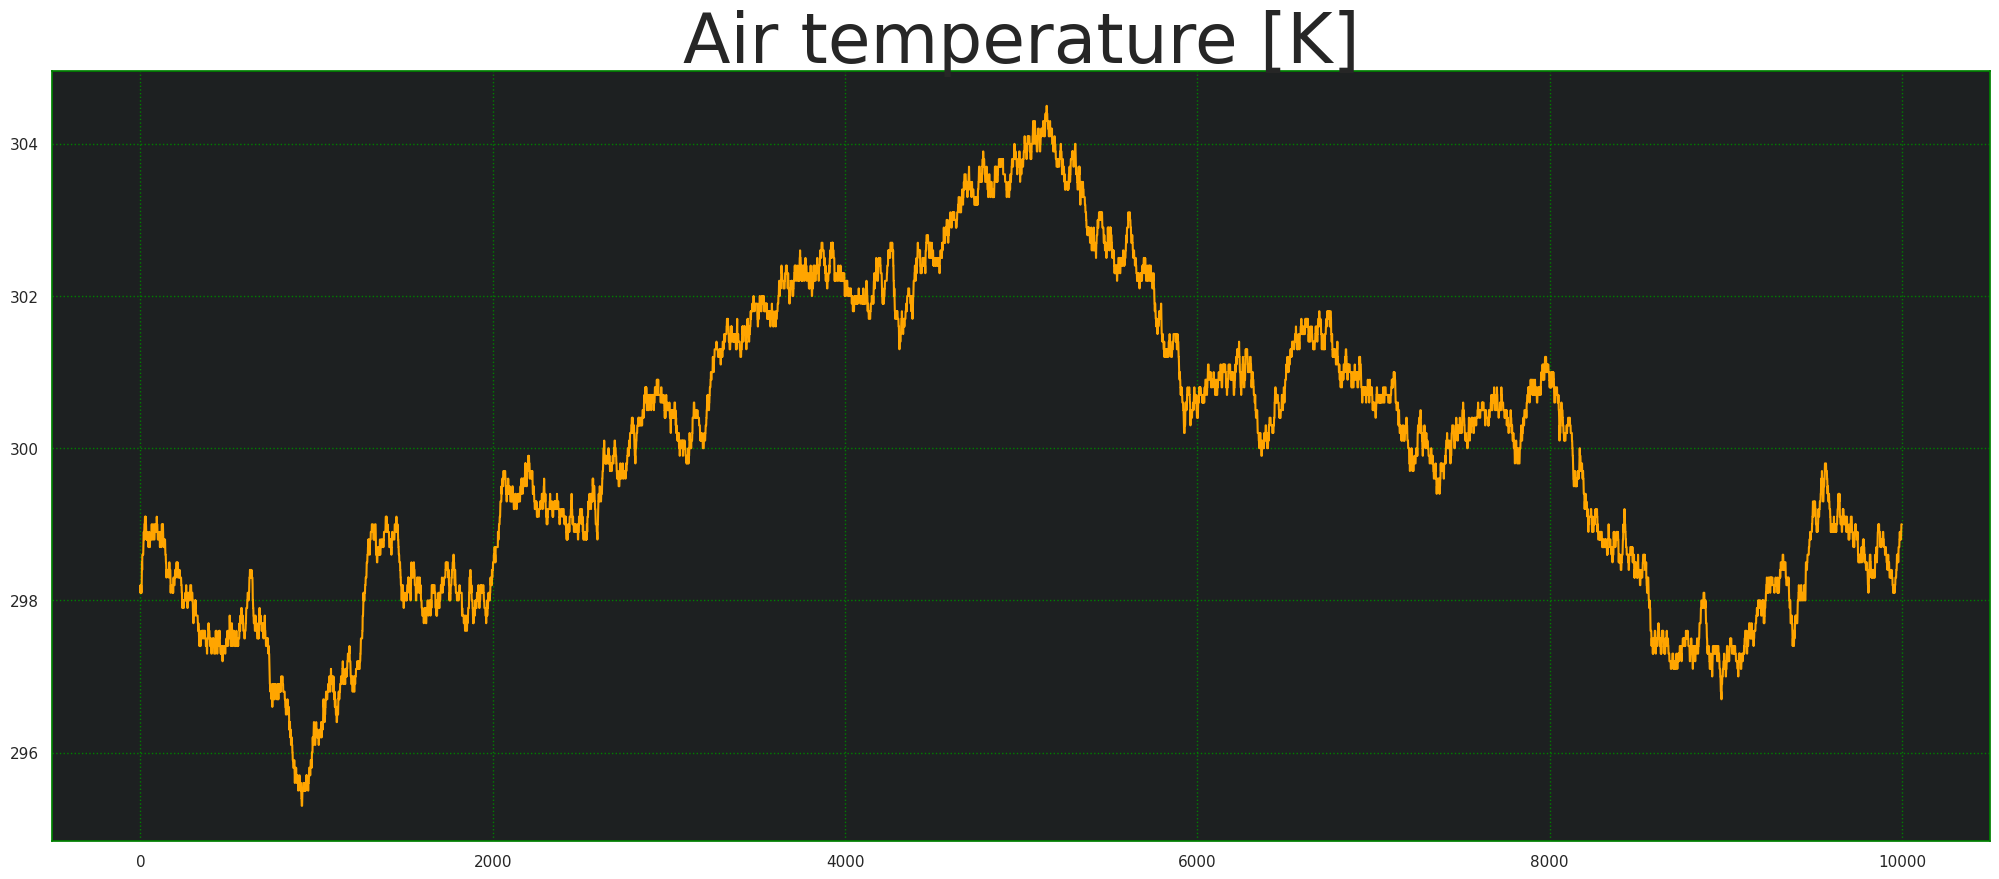

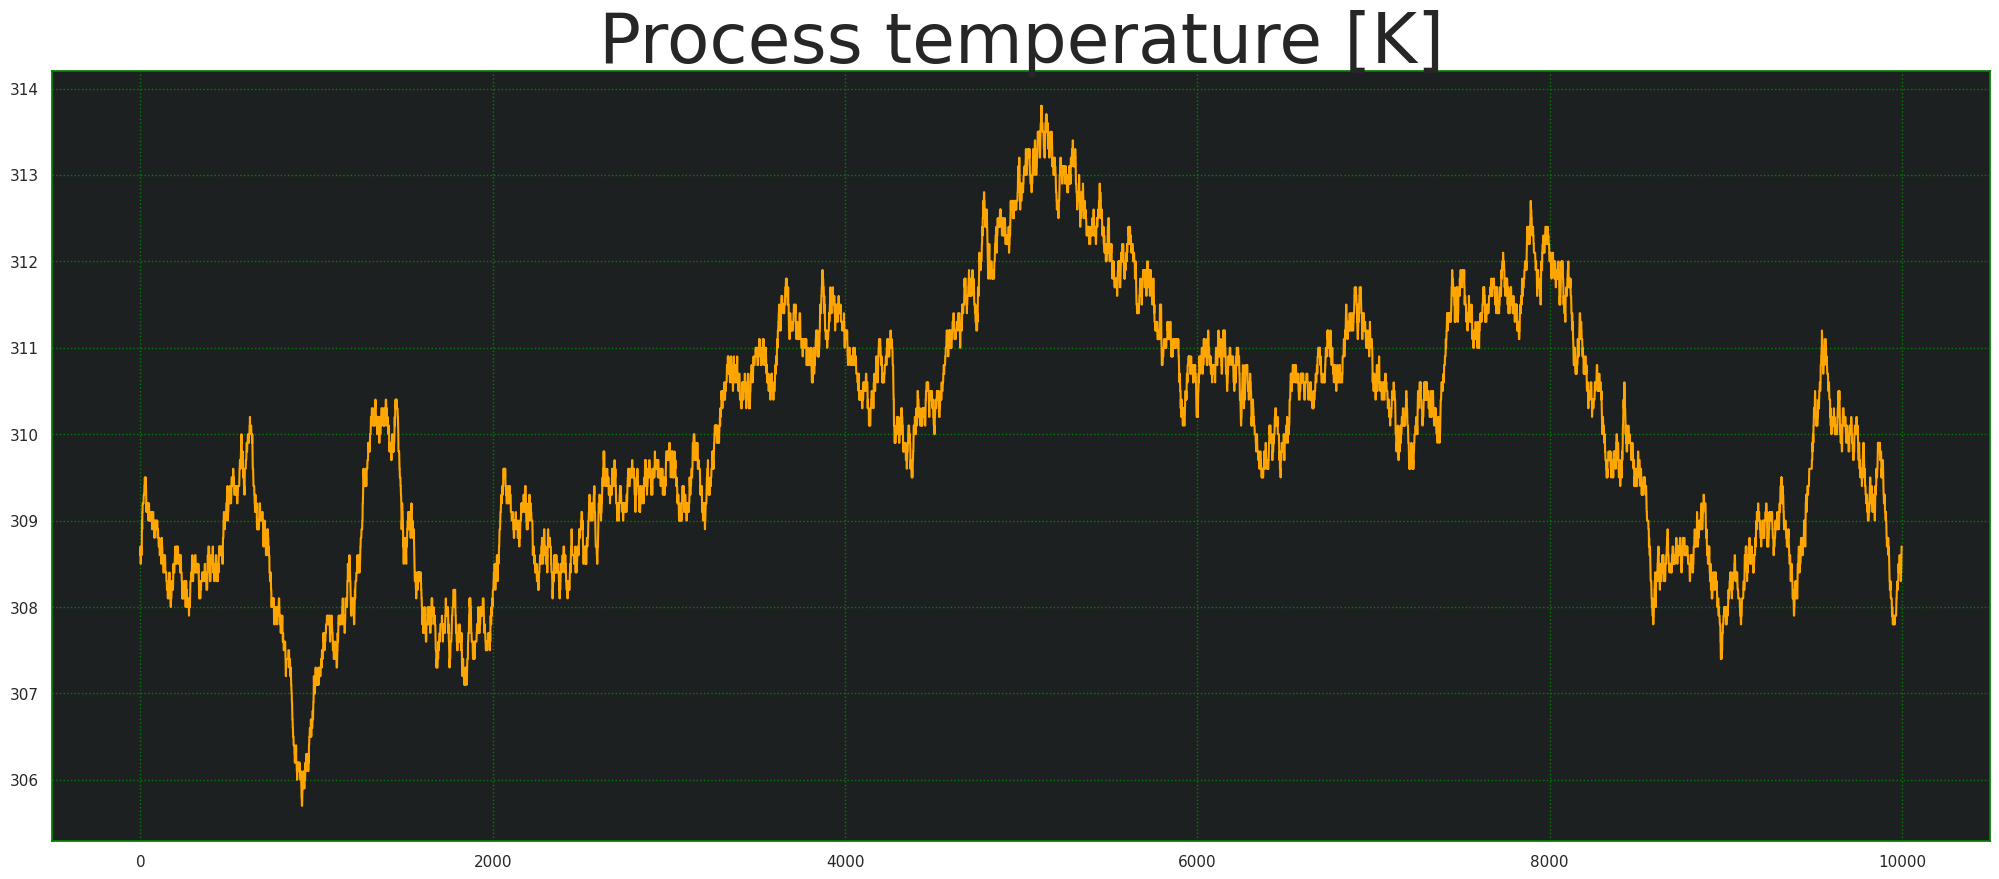

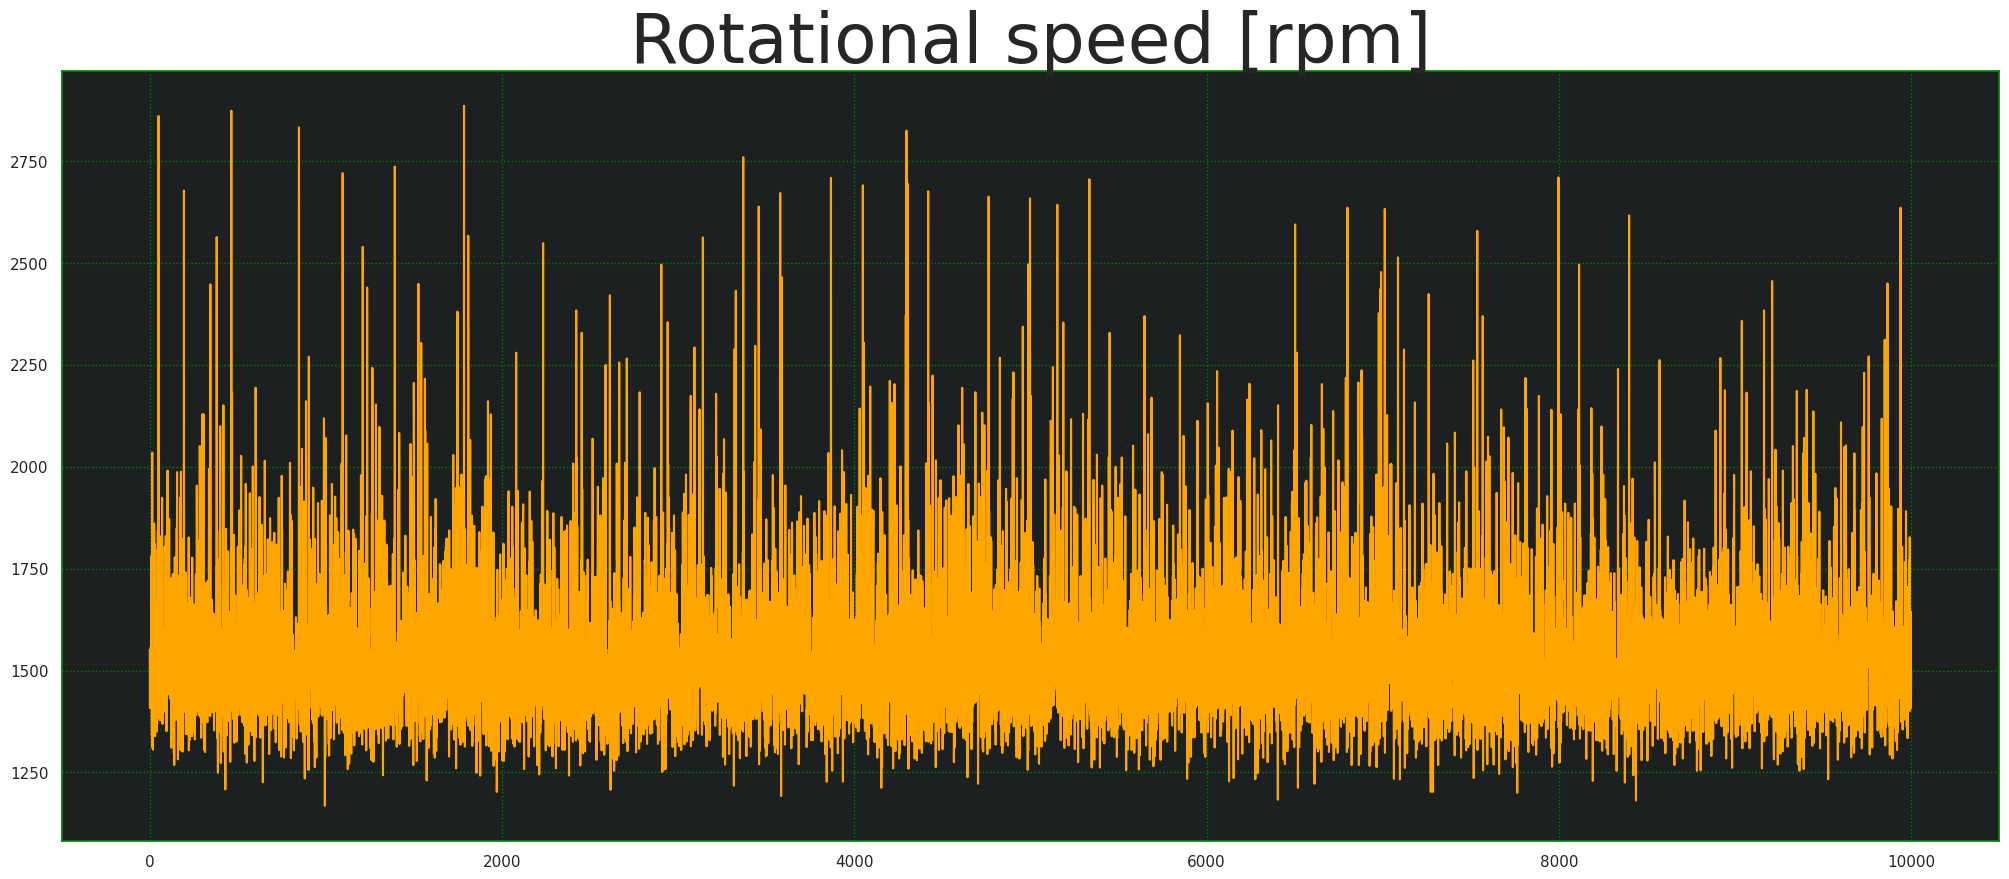

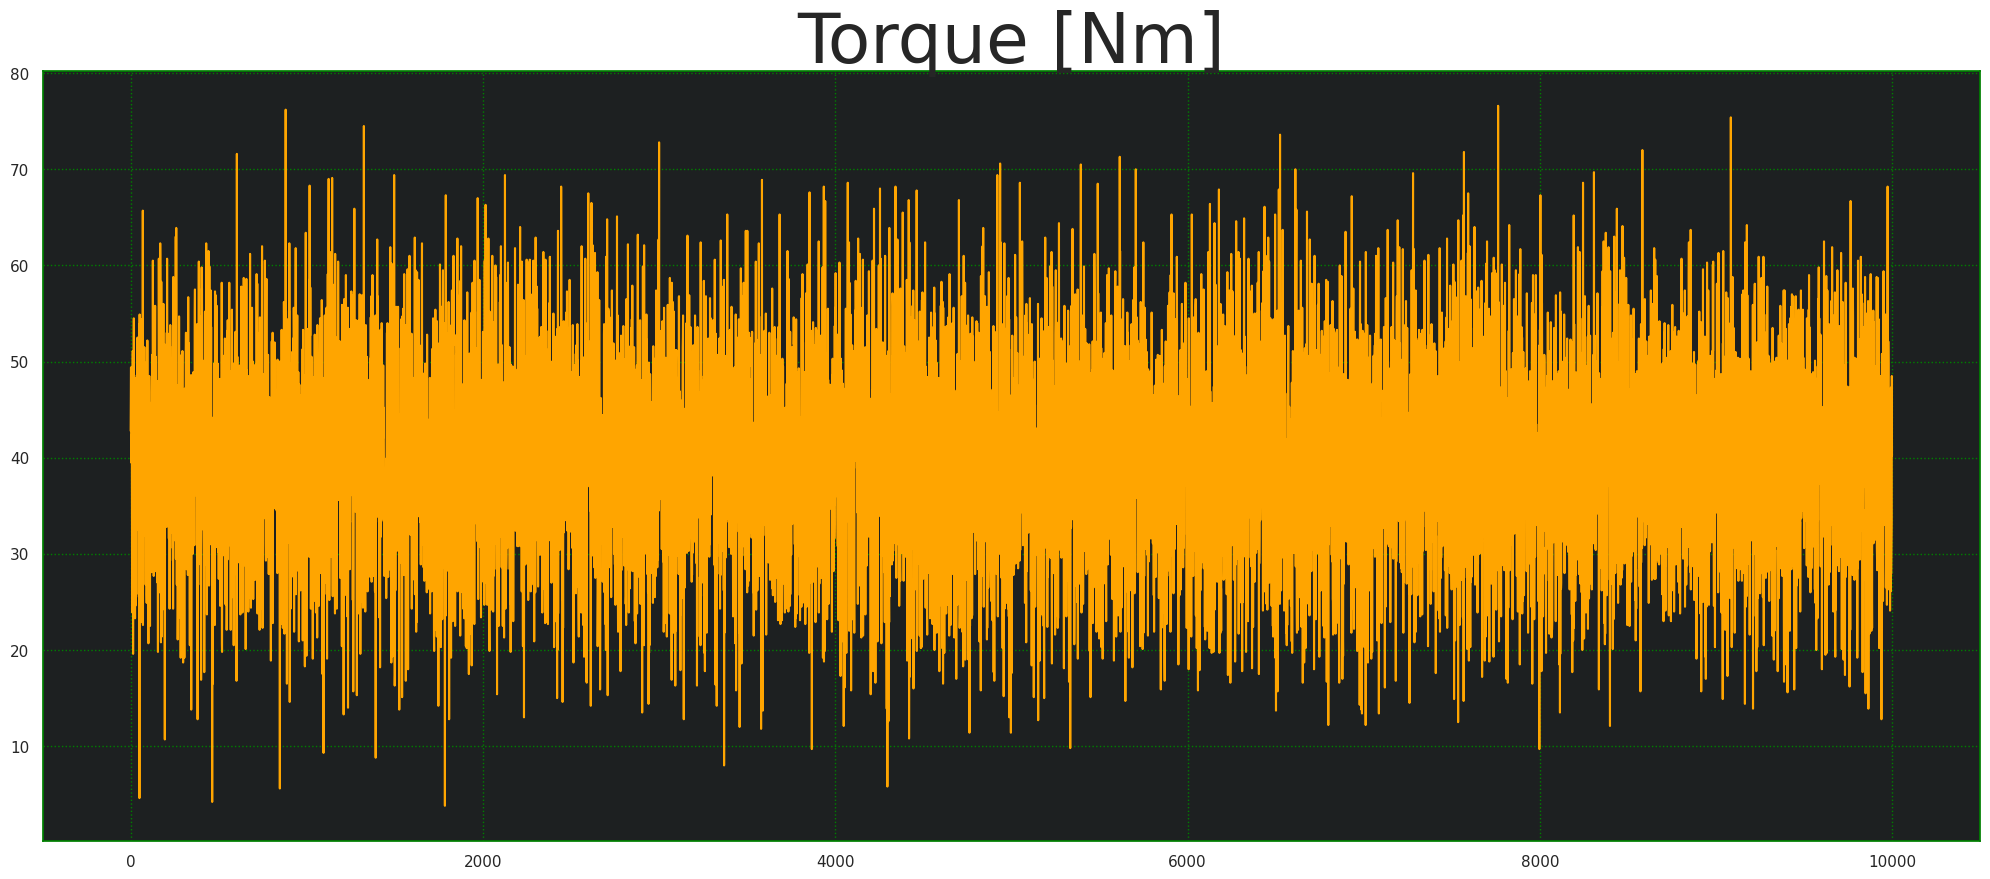

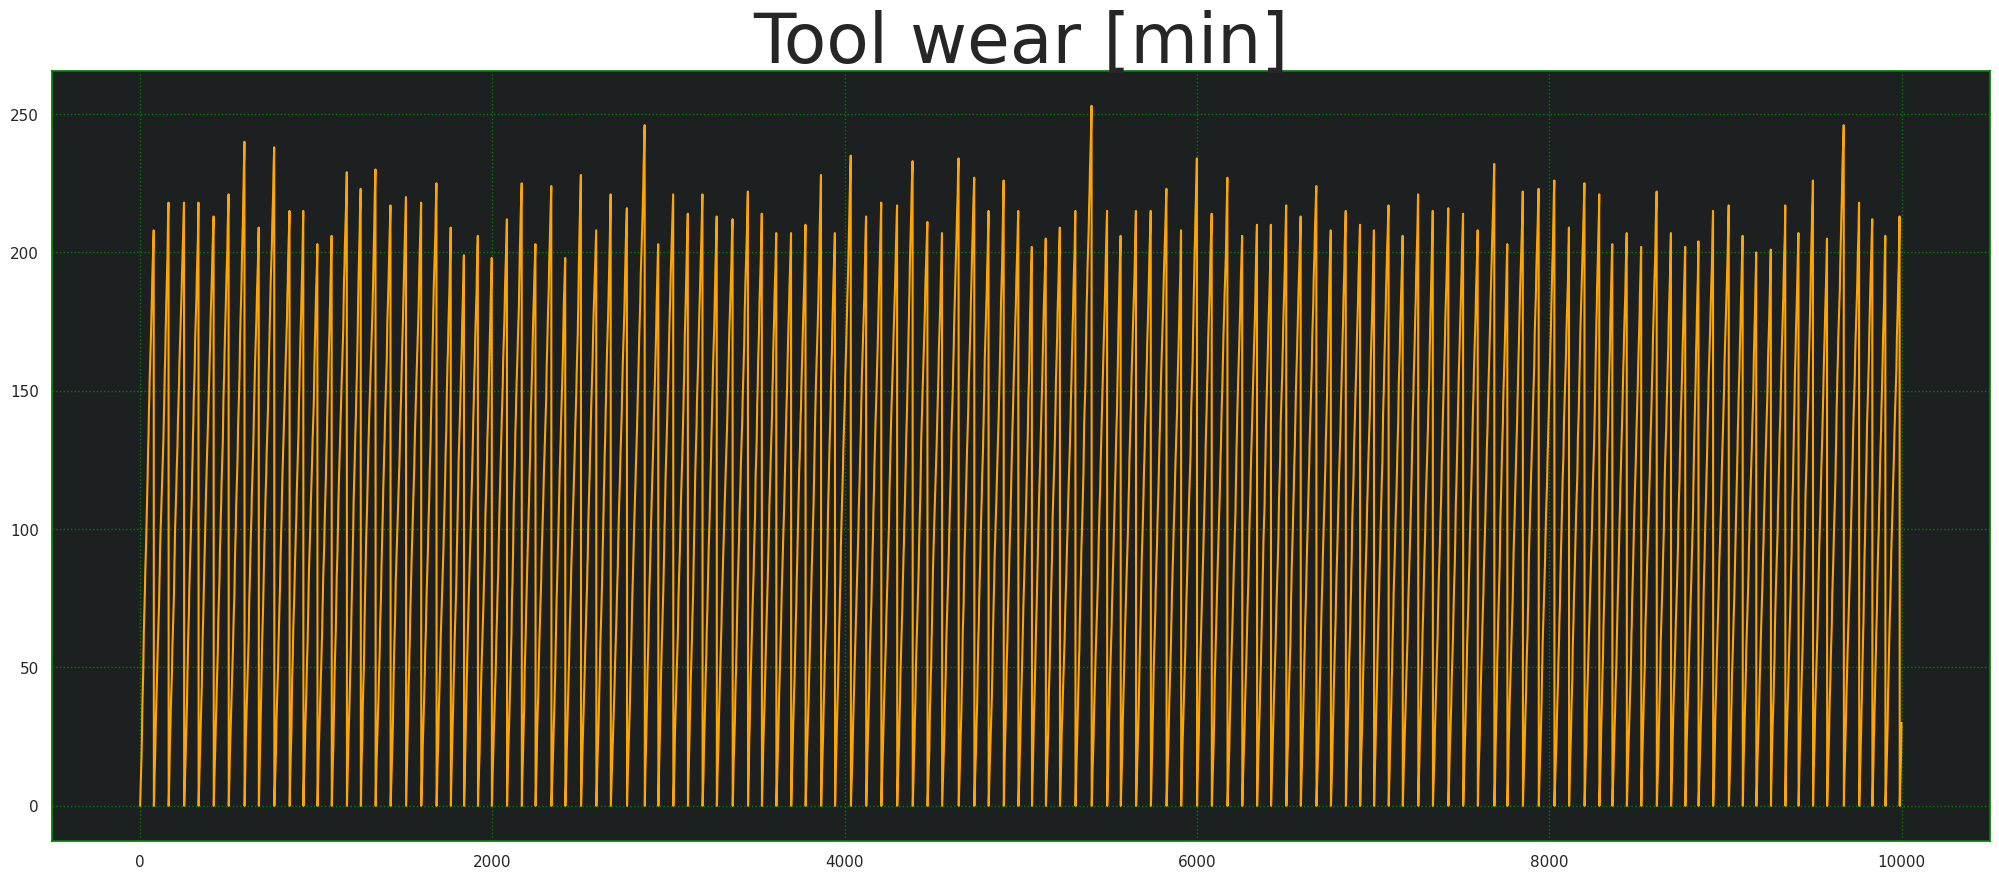

In [82]:
# Look for outliers
for non_binary_column in ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']:
    plt.figure(figsize=(25,10))
    plt.plot(cleaned_dataset[non_binary_column].to_numpy(), color='orange')
    plt.title(non_binary_column, fontsize=50)
    plt.show()

Before cleaning: 10000
Treating series: 0       1551
1       1408
2       1498
3       1433
4       1408
        ... 
9995    1604
9996    1632
9997    1645
9998    1408
9999    1500
Name: Rotational speed [rpm], Length: 10000, dtype: int64
Treating series: 0       42.8
1       46.3
2       49.4
3       39.5
4       40.0
        ... 
9995    29.5
9996    31.8
9997    33.4
9998    48.5
9999    40.2
Name: Torque [Nm], Length: 9836, dtype: float64
After cleaning: 9815


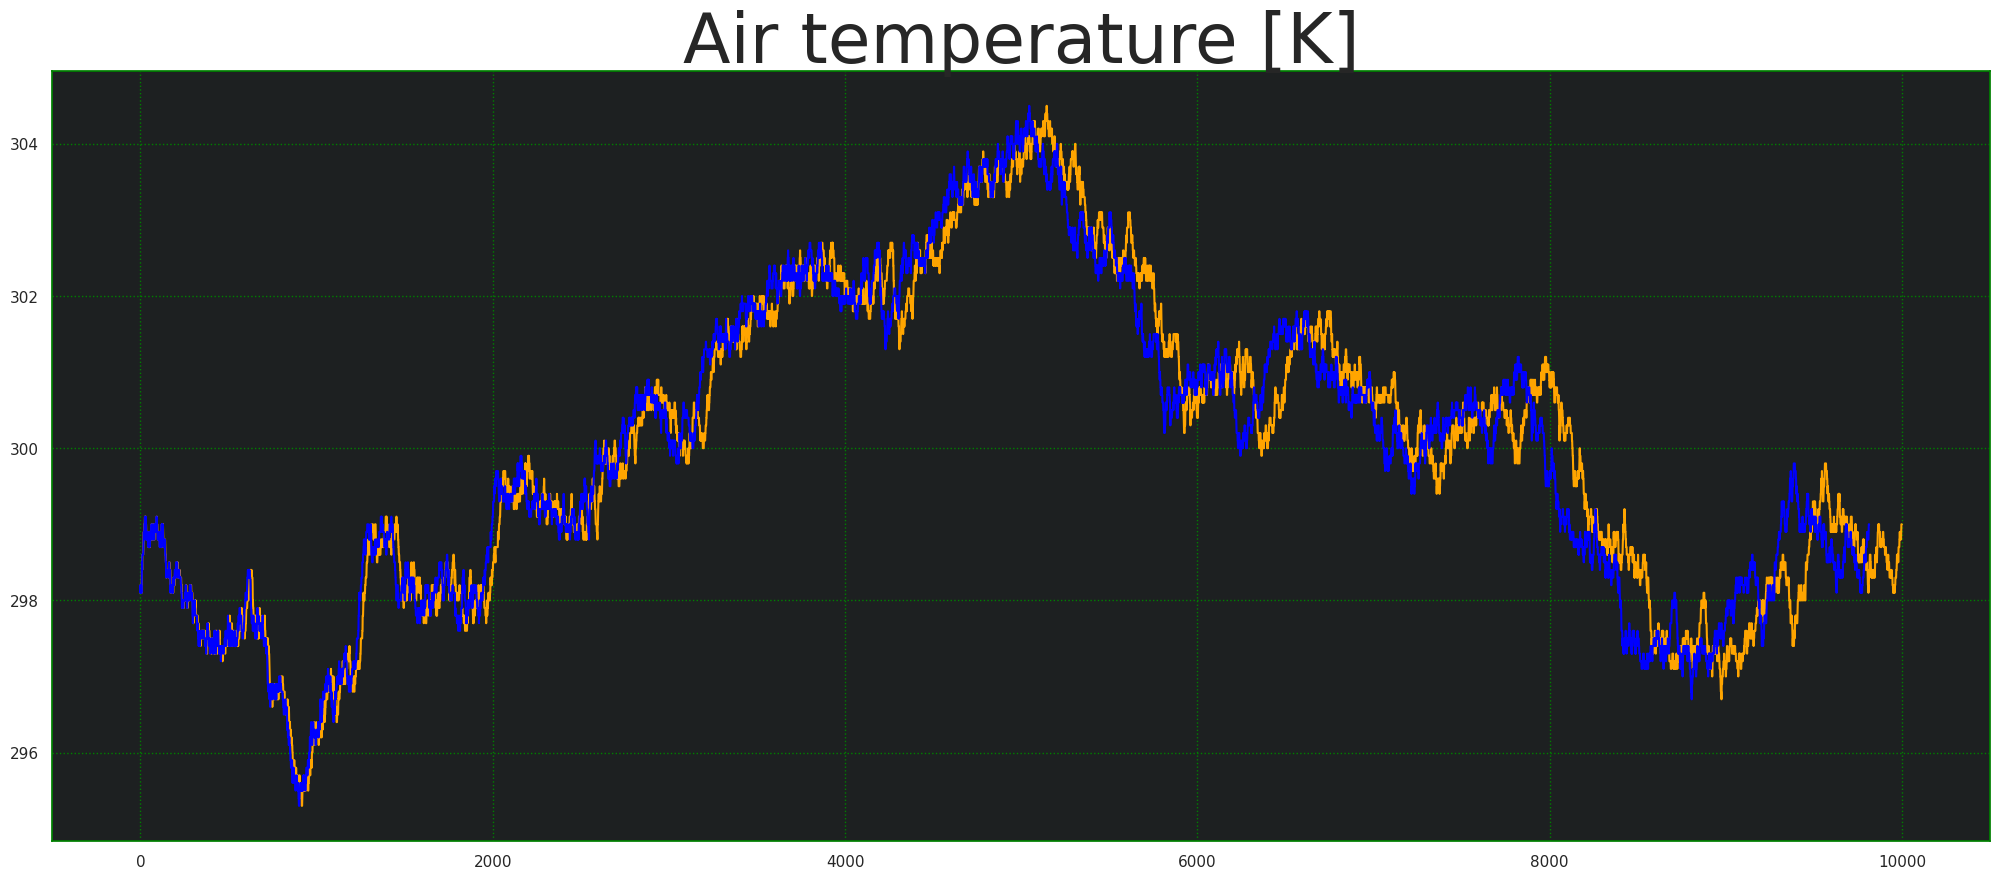

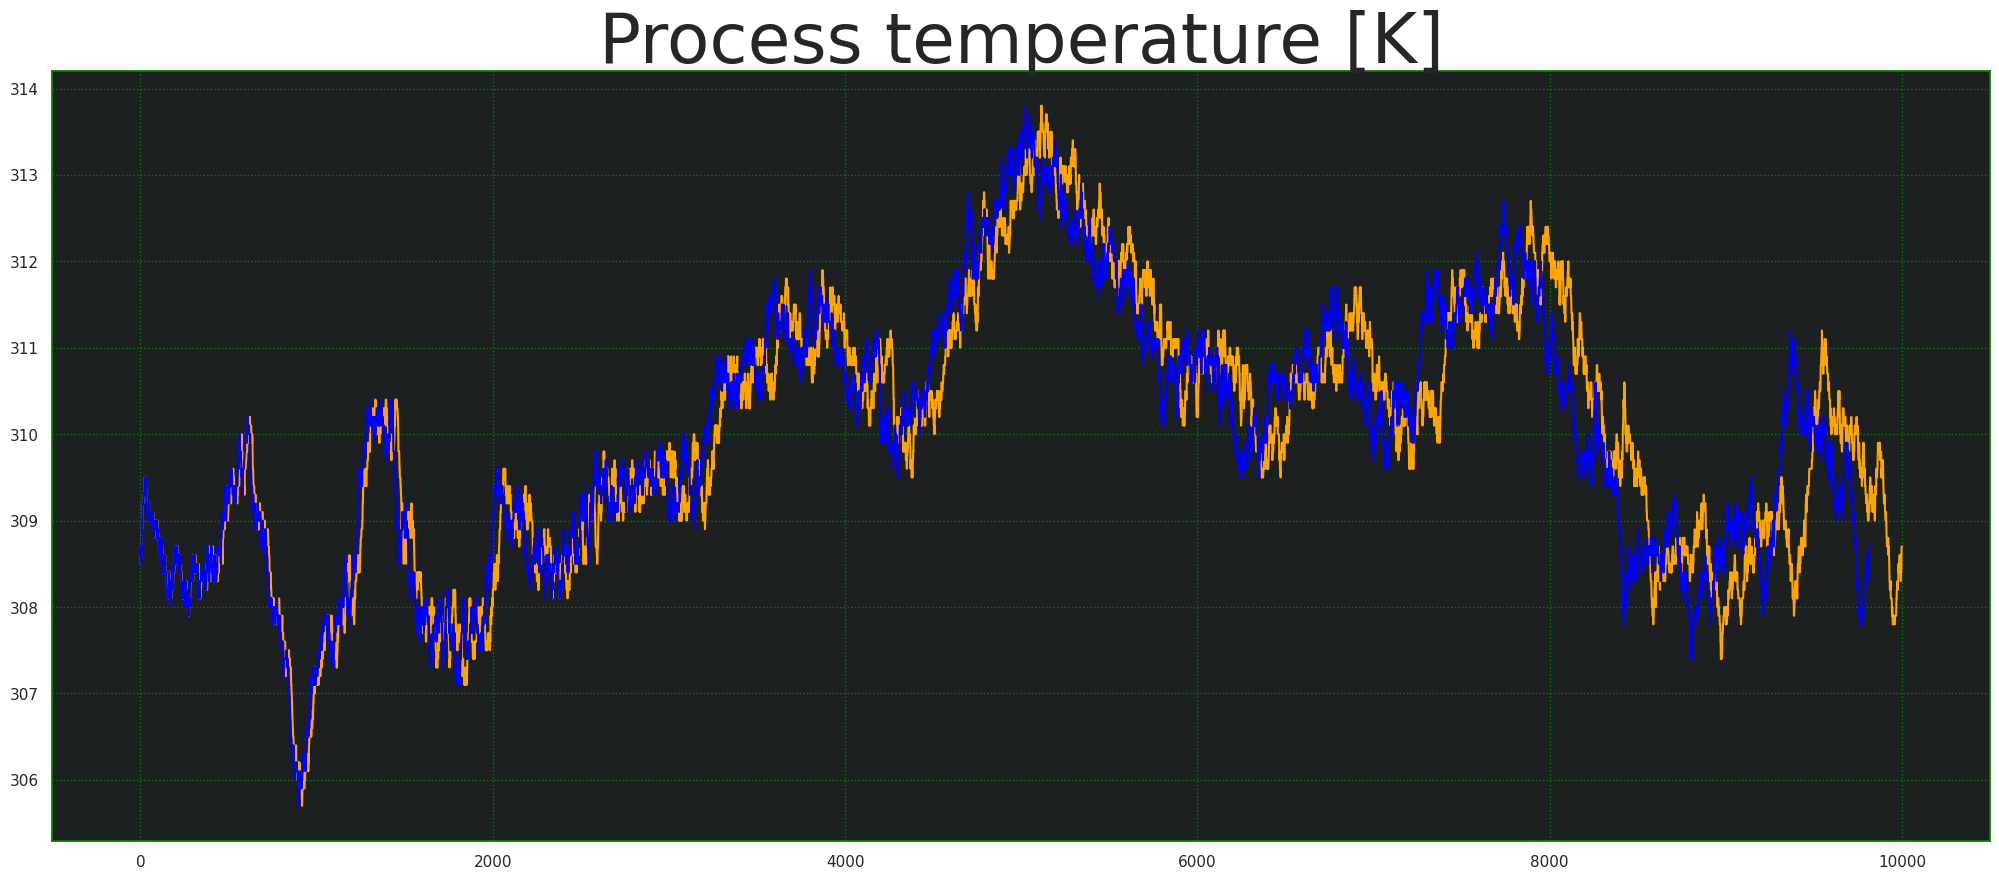

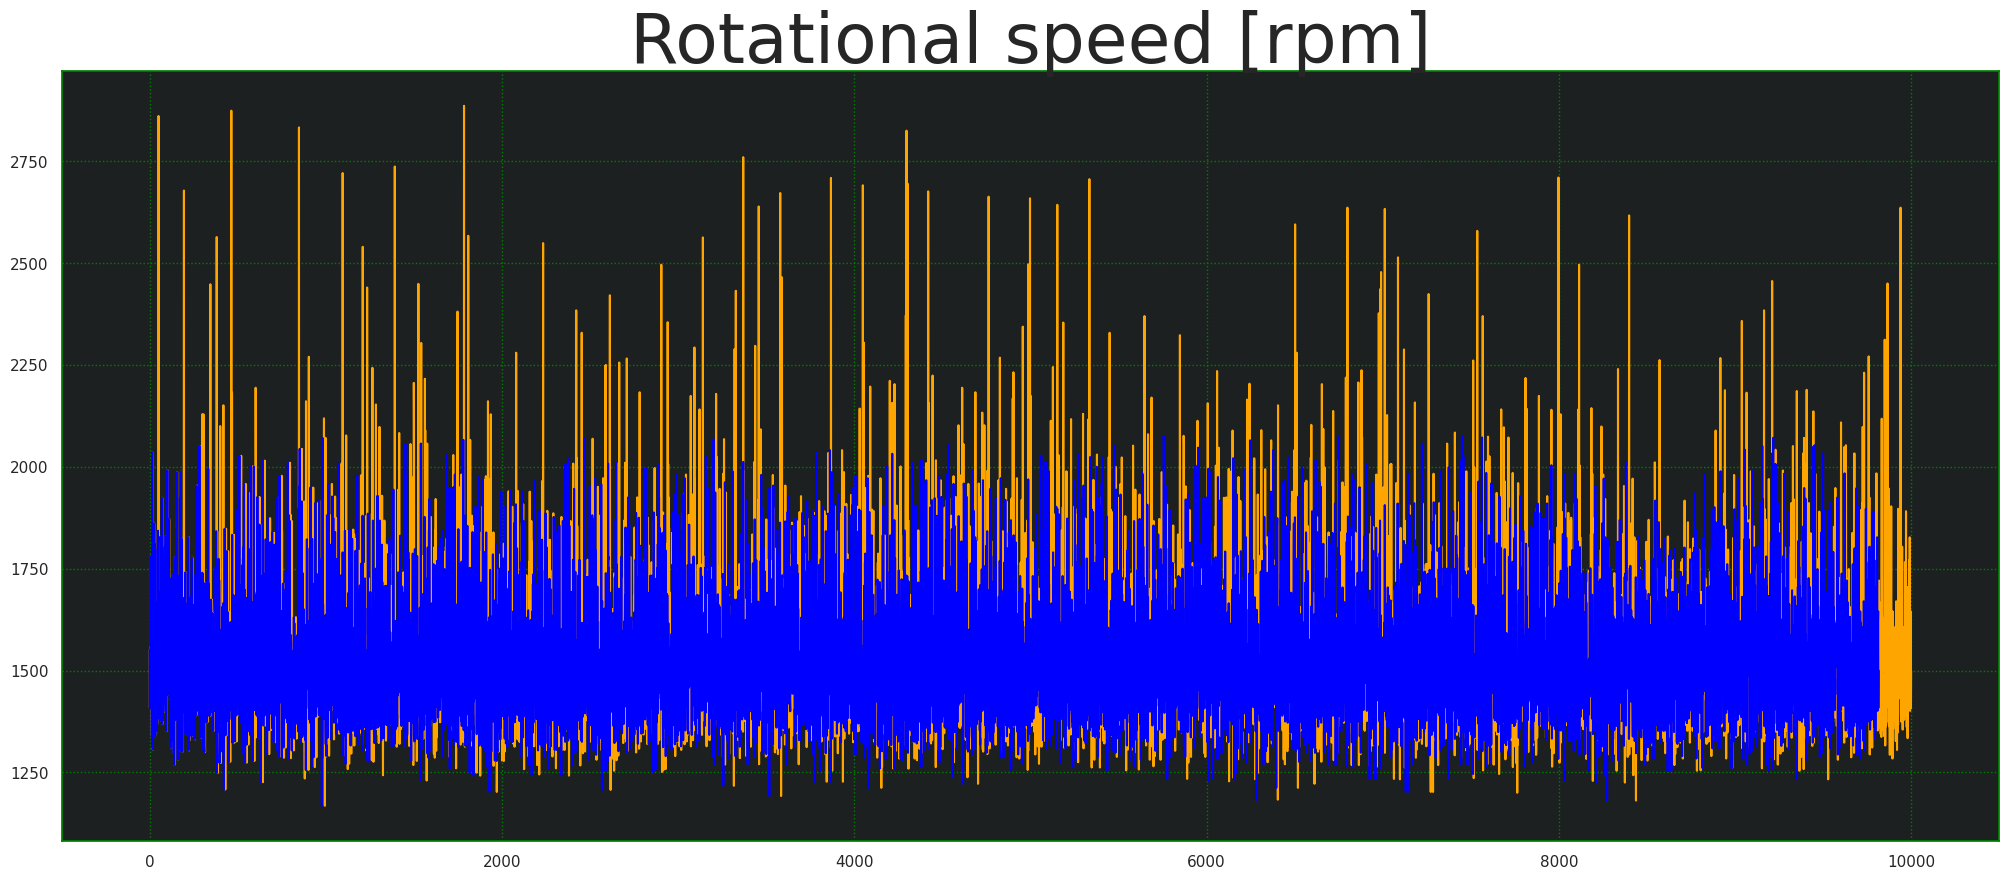

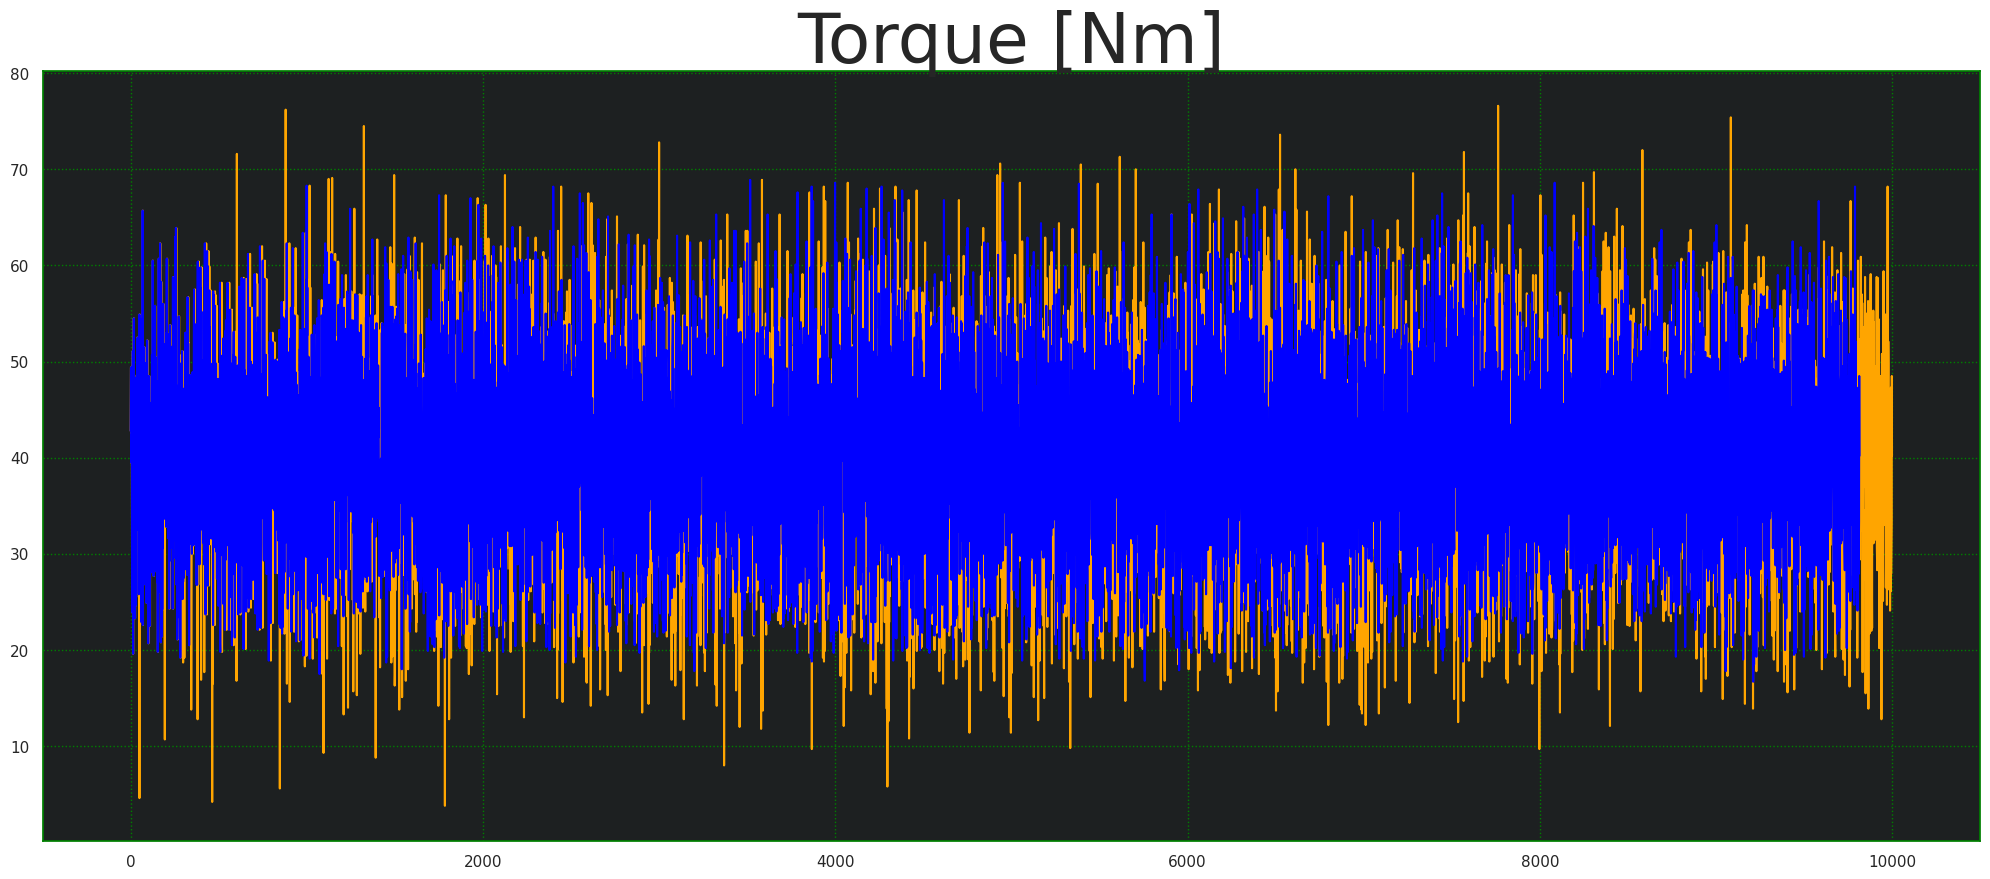

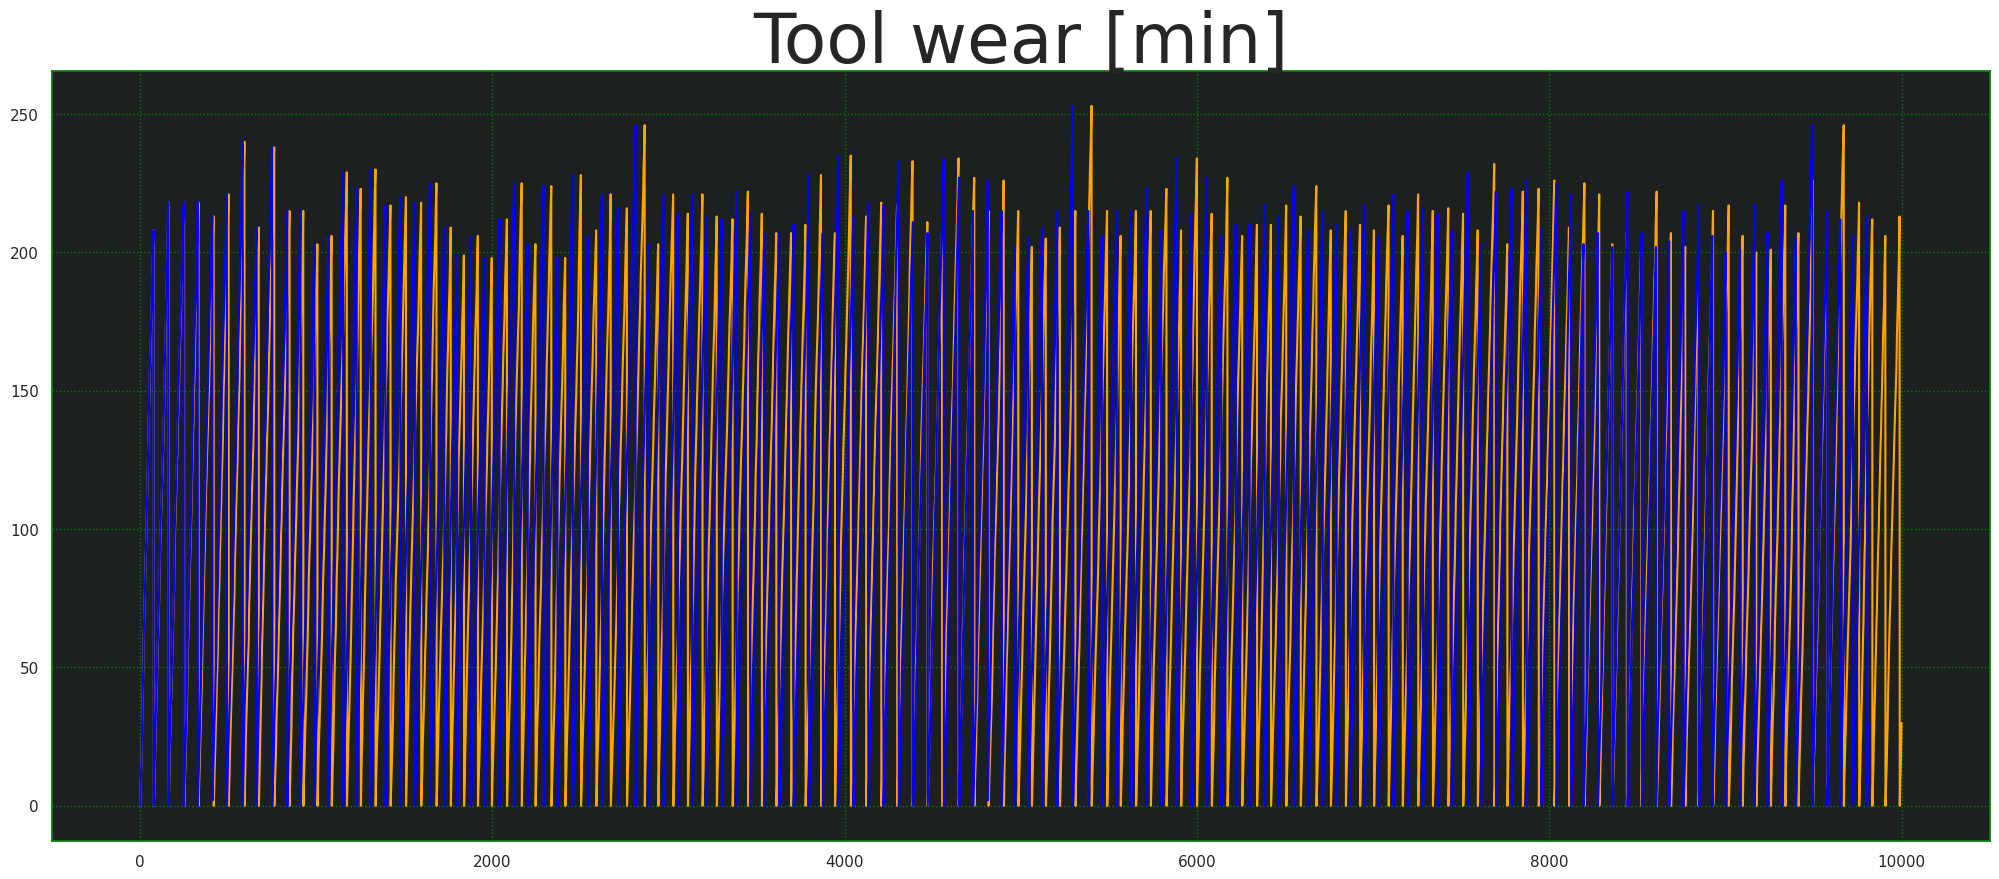

In [164]:
normalized_dataset = cleaned_dataset.copy()

# Remove some outliers

def if_not_outlier(series):  # returns Series
    return np.abs(
        series - series.mean()
    ) <= (3 * series.std()) 

print(f'Before cleaning: {len(cleaned_dataset)}')

for feature in ['Rotational speed [rpm]', 'Torque [Nm]']:
    normalized_dataset = normalized_dataset[if_not_outlier(normalized_dataset[feature])]

print(f'After cleaning: {len(normalized_dataset)}')

for non_binary_column in ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']:
    plt.figure(figsize=(25,10))
    plt.plot(cleaned_dataset[non_binary_column].to_numpy(), color='orange')
    plt.plot(normalized_dataset[non_binary_column].to_numpy(), color='blue')
    plt.title(non_binary_column, fontsize=50)
    plt.show()

In [189]:
REMOVE_OUTLIERS = False

df = normalized_dataset.copy() if REMOVE_OUTLIERS else cleaned_dataset.copy()

y = df.iloc[:,-1]
df.drop(['Failure Type'], axis=1, inplace=True)

y

0       No Failure
1       No Failure
2       No Failure
3       No Failure
4       No Failure
           ...    
9995    No Failure
9996    No Failure
9997    No Failure
9998    No Failure
9999    No Failure
Name: Failure Type, Length: 10000, dtype: object

In [167]:
# Let's apply scaler
scaler = MinMaxScaler()
scaler.fit(df)
scaled_dataset = pd.DataFrame(
    data=scaler.transform(df),
    columns=df.columns,
    index=df.index)

scaled_dataset.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,0.304348,0.358025,0.222934,0.535714,0.000000
1,0.315217,0.370370,0.139697,0.583791,0.011858
2,0.304348,0.345679,0.192084,0.626374,0.019763
3,0.315217,0.358025,0.154249,0.490385,0.027668
4,0.315217,0.370370,0.139697,0.497253,0.035573


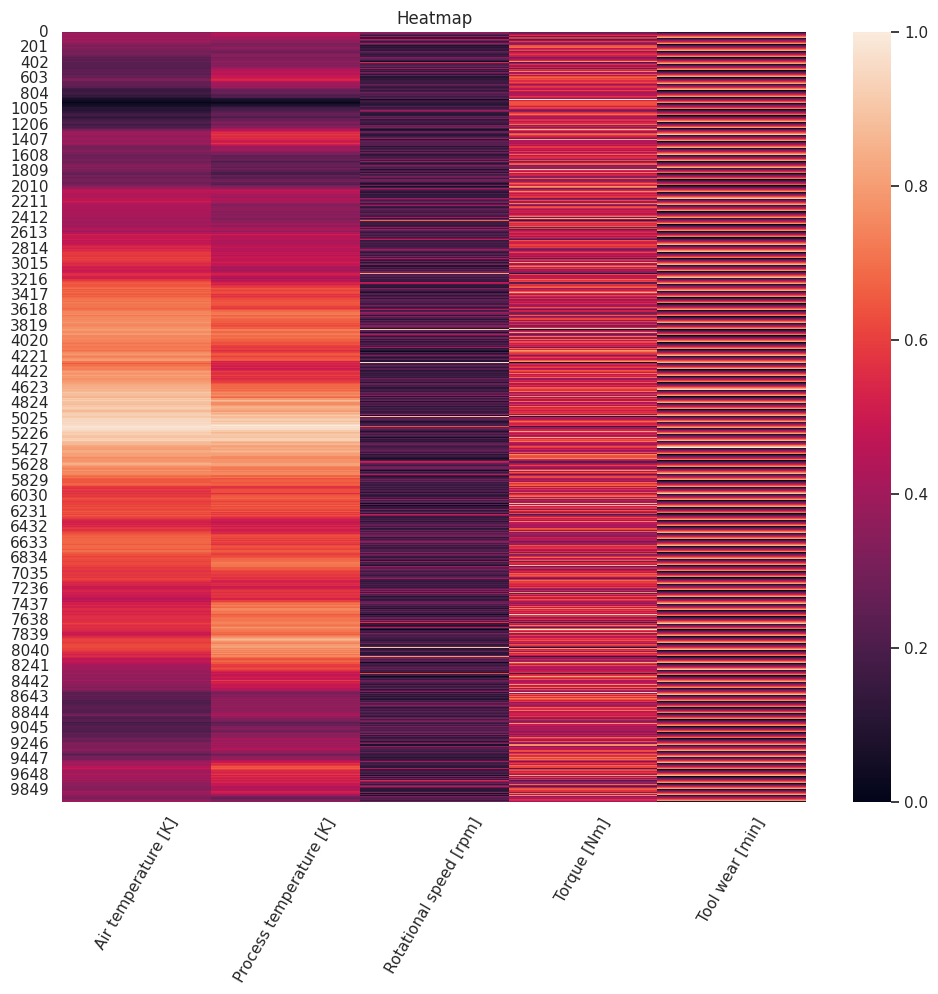

In [168]:
# And draw heatmap to see if dataset is imbalanced
def draw_heatmap(title: str):
    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(scaled_dataset)
    ax.set_title(title)
    
    plt.xticks(rotation=60)

    plt.show()
    
draw_heatmap('Heatmap')

In [169]:
# Split it to train|test
X_train, X_test, y_train, y_test = train_test_split(
    scaled_dataset,
    y,
    test_size=0.2,
    random_state=42,
)
X_test.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
6252,0.597826,0.567901,0.215367,0.443681,0.782609
4684,0.902174,0.753086,0.147264,0.563187,0.399209
1731,0.326087,0.271605,0.184517,0.524725,0.462451
4742,0.869565,0.691358,0.246799,0.410714,0.055336
4521,0.771739,0.580247,0.405704,0.276099,0.509881


In [170]:
y

0       No Failure
1       No Failure
2       No Failure
3       No Failure
4       No Failure
           ...    
9995    No Failure
9996    No Failure
9997    No Failure
9998    No Failure
9999    No Failure
Name: Failure Type, Length: 10000, dtype: object

In [171]:
# Try some models

def get_score(method: str, pred):
    print(classification_report(y_test, pred))
    score = accuracy_score(y_test, pred)*100
    print(f'{method} score: {score}%')
    return score
    
DT = DecisionTreeClassifier()
DT.fit(X_train,y_train)
decision_tree_score = get_score('DT', DT.predict(X_test))

KNN = KNeighborsClassifier()
KNN.fit(X_train,y_train)
knn_score = get_score('KNN', KNN.predict(X_test))

RF = RandomForestClassifier()
RF.fit(X_train,y_train)
random_forest_score = get_score('RF', RF.predict(X_test))

SVC_L = SVC(kernel='linear')
SVC_L.fit(X_train, y_train)
svm_l_score = get_score('SVM linear', SVC_L.predict(X_test))

SVC_P = SVC(kernel='poly')
SVC_P.fit(X_train, y_train)
svm_p_score = get_score('SVM poly', SVC_P.predict(X_test))

LR = LogisticRegression()
LR.fit(X_train, y_train)
lr_score = get_score('LR', LR.predict(X_test))

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.87      0.87      0.87        15
              No Failure       0.99      0.99      0.99      1935
      Overstrain Failure       0.53      0.62      0.57        13
           Power Failure       0.71      0.85      0.77        20
         Random Failures       0.00      0.00      0.00         6
       Tool Wear Failure       0.00      0.00      0.00        11

                accuracy                           0.97      2000
               macro avg       0.52      0.55      0.53      2000
            weighted avg       0.97      0.97      0.97      2000

DT score: 97.39999999999999%
                          precision    recall  f1-score   support

Heat Dissipation Failure       0.50      0.33      0.40        15
              No Failure       0.97      1.00      0.99      1935
      Overstrain Failure       1.00      0.23      0.38        13
           Power Failure       0.80      0.

/home/alexander/education/SPbPU/Software-Development-Technologies/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexander/education/SPbPU/Software-Development-Technologies/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexander/education/SPbPU/Software-Development-Technologies/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted s

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.85      0.73      0.79        15
              No Failure       0.99      1.00      0.99      1935
      Overstrain Failure       0.80      0.62      0.70        13
           Power Failure       0.80      0.80      0.80        20
         Random Failures       0.00      0.00      0.00         6
       Tool Wear Failure       0.00      0.00      0.00        11

                accuracy                           0.98      2000
               macro avg       0.57      0.52      0.55      2000
            weighted avg       0.97      0.98      0.98      2000

RF score: 98.15%
                          precision    recall  f1-score   support

Heat Dissipation Failure       0.00      0.00      0.00        15
              No Failure       0.97      1.00      0.98      1935
      Overstrain Failure       0.00      0.00      0.00        13
           Power Failure       0.00      0.00      0.00

/home/alexander/education/SPbPU/Software-Development-Technologies/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexander/education/SPbPU/Software-Development-Technologies/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexander/education/SPbPU/Software-Development-Technologies/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted s

In [172]:
# compare scores
df_scores = pd.DataFrame(data=[
    ['DecisionTree', decision_tree_score],
    ['RandomForest', random_forest_score],
    ['K-nearest neighbors', knn_score],
    ['SVM linear', svm_l_score],
    ['SVM poly', svm_p_score],
    ['LogisticRegression', lr_score],
], columns=['Model', 'Accuracy'])
df_scores

,Model,Accuracy
0,DecisionTree,97.40
1,RandomForest,98.15
2,K-nearest neighbors,97.15
3,SVM linear,96.75
4,SVM poly,98.00
5,LogisticRegression,96.75


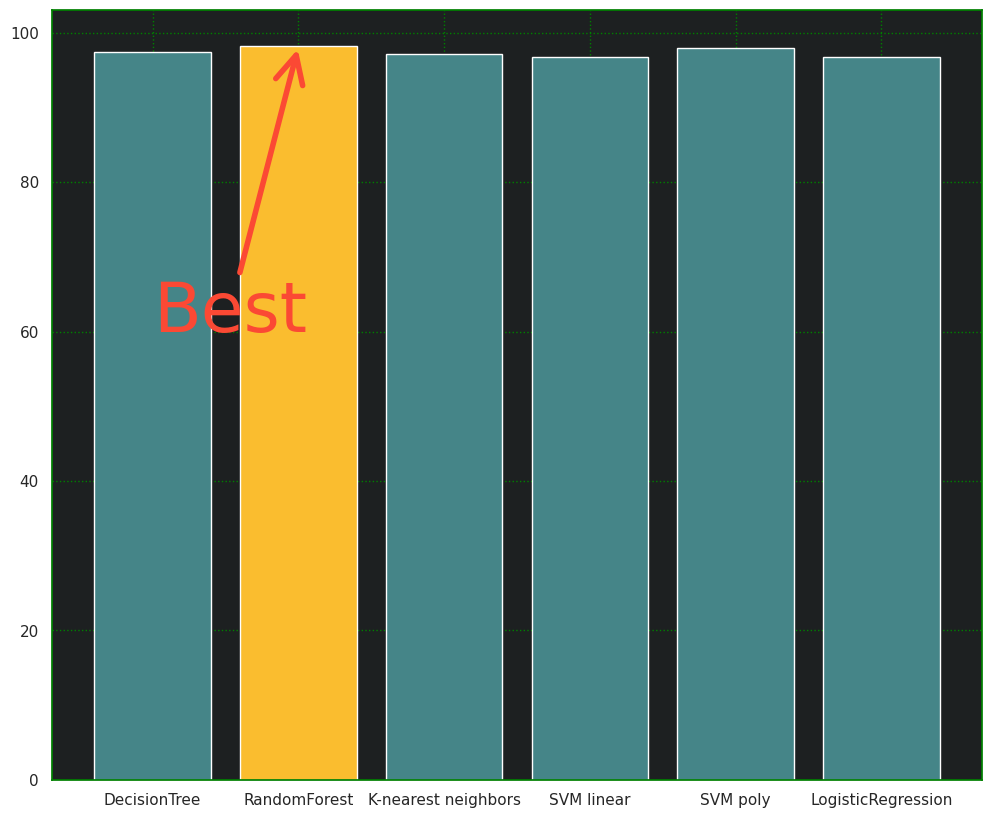

In [173]:
# Let's compare results at scale


plt.figure(figsize=(12, 10))
0
winner = df_scores['Accuracy'].idxmax()
colors = ['#458588'] * len(df_scores)
colors[winner] = '#fabd2f'

plt.bar(df_scores['Model'], df_scores['Accuracy'], color=colors)        
plt.annotate('Best', xy=(winner, df_scores['Accuracy'].max()), arrowprops={
    'arrowstyle': '->',
    'color': '#fb4934',
    'linewidth': 4,
}, xytext=(0, 60), fontsize = 50, color='#fb4934')
plt.show()

In [192]:
scaled_dataset

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,0.304348,0.358025,0.222934,0.535714,0.000000
1,0.315217,0.370370,0.139697,0.583791,0.011858
2,0.304348,0.345679,0.192084,0.626374,0.019763
3,0.315217,0.358025,0.154249,0.490385,0.027668
4,0.315217,0.370370,0.139697,0.497253,0.035573
...,...,...,...,...,...
9995,0.380435,0.333333,0.253783,0.353022,0.055336
9996,0.391304,0.333333,0.270081,0.384615,0.067194
9997,0.402174,0.358025,0.277648,0.406593,0.086957
9998,0.402174,0.370370,0.139697,0.614011,0.098814


In [191]:
dfNN = scaled_dataset.copy()
yNN = pd.get_dummies(y)
yNN

,Heat Dissipation Failure,No Failure,Overstrain Failure,Power Failure,Random Failures,Tool Wear Failure
0,0,1,0,0,0,0
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0
...,...,...,...,...,...,...
9995,0,1,0,0,0,0
9996,0,1,0,0,0,0
9997,0,1,0,0,0,0
9998,0,1,0,0,0,0


In [196]:
# Split it to train|test
X_train, X_test, y_train, y_test = train_test_split(
    dfNN,
    yNN,
    test_size=0.2,
    random_state=0,
)
X_train

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
7389,0.489130,0.604938,0.313737,0.394231,0.490119
9275,0.315217,0.370370,0.254366,0.351648,0.185771
2995,0.565217,0.506173,0.222352,0.461538,0.584980
5316,0.902174,0.876543,0.303260,0.402473,0.063241
356,0.250000,0.333333,0.133877,0.619505,0.249012
...,...,...,...,...,...
9225,0.293478,0.419753,0.379511,0.271978,0.474308
4859,0.913043,0.827160,0.213620,0.478022,0.422925
3264,0.652174,0.543210,0.167055,0.553571,0.743083
9845,0.326087,0.419753,0.147264,0.598901,0.130435


In [199]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout  
from tensorflow.keras.callbacks import EarlyStopping


model = Sequential()
model.add(Dense(16, input_dim=5, activation='relu')) # we have 5 features, first hidden layer w/ 10 neurons
model.add(Dense(8, activation='relu'))  # second hidden layer w/ 8 neurons
model.add(Dense(6, activation='sigmoid')) # final layer: 6 types of failure (5 failures + 1 no failure)


model.compile(
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    optimizer='rmsprop',
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=15,
    verbose=0,
    mode='auto',
)

hist = model.fit(
    X_train,
    y_train,
    validation_split=0.15,
    epochs=500,
    verbose=0,
    callbacks=[earlystop],
    batch_size=256,  # smaller batch => overfitting
)

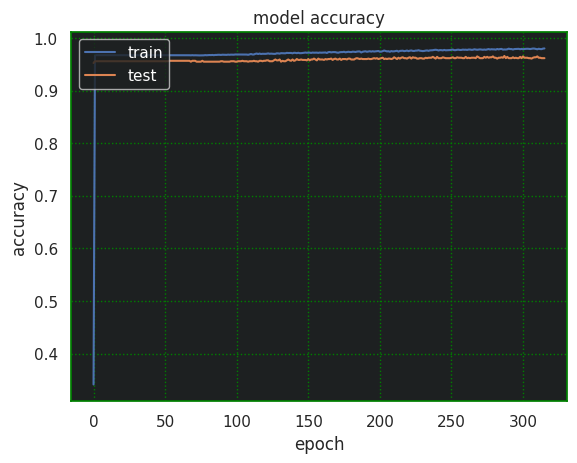

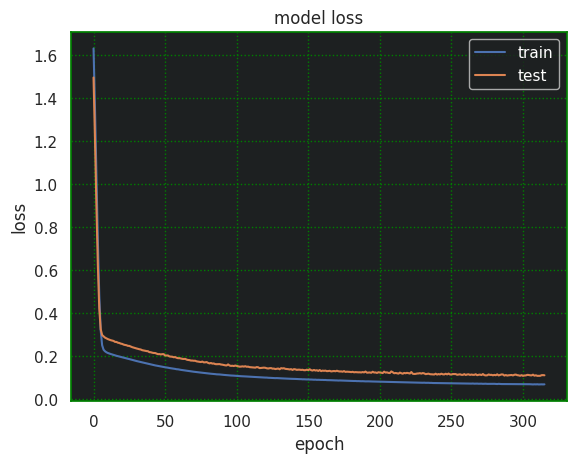

In [200]:
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left', labelcolor='white')
plt.show()

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right', labelcolor='white')
plt.show()

In [201]:
# what accuracy we got?
max(hist.history['val_accuracy'])

0.965833306312561

In [221]:
model.save('NN.h5')